
# Oct 14, 2021 meeting. Request for SW precip plots for CPC/CAM6/CCM3
1. area average (ocean to 105W and 30N-45N) precip changes in mm/day and percentage of total. 
   3 month running average from 1979-2021
2. box and whiskers for 4 most recent seasons (as in Jennie's plots). Plot model ensemble members, ensemble mean and obs
3. How anomalous was this year compared to past? Try do the same for models, including each ensemble member separately.

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xesmf as xe

import cartopy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import warnings
warnings.filterwarnings("ignore")

In [3]:
def fix_grids(ds,domain,time_start,times):
    if 'X' in ds.coords:
        ds = ds.rename({'Y':'lat','X':'lon'})
    if 'T' in ds.coords:
        ds = ds.rename({'T':'time'})
    if 'P' in ds.coords:
        ds = ds.rename({'P':'plev'})
        
    ds = ds.sortby('lat').sel(lat=slice(domain[2],domain[3]))
    ds.coords['lon'] = (ds.coords['lon'] - domain[0]) % 360 +  domain[0] ; ds = ds.sortby('lon')
    ds = ds.sel(lon=slice(domain[0],domain[1]))
    ds['time'] = pd.date_range(time_start,periods=len(ds.time), freq='MS').shift(15,freq='D')
    ds = ds.sel(time=slice(times[0],times[1]))
    return ds

def load_model(domain,time_start,times,prefix,varlist):
    filelist = [f'{prefix}/{var}.nc' for var in varlist]
    ds = xr.open_mfdataset(filelist,decode_times=False)
    return fix_grids(ds,domain,time_start,times)

def get_data(gtype,domain,time_range,mean=True):
    if gtype == 'NOAA':
        prefix = 'http://iridl.ldeo.columbia.edu'
        if not os.path.exists('NOAA_rain.nc'):    
            data   = 'SOURCES/.NOAA/.NCEP/.CPC/.UNIFIED_PRCP/.GAUGE_BASED/.GLOBAL/.v1p0/'
            url = f'{prefix}/{data}.RETRO/.rain/{data}.REALTIME/.rain/appendstream/monthlyAverage/data.nc'
            os.system(f'wget {url}; mv data.nc NOAA_rain.nc')
        dsn = xr.open_dataset('NOAA_rain.nc',decode_times=False)
        dst = fix_grids(dsn,domain,'1979-01',time_range)
       
    # UCAR - CAM6 - ERSSTv5 - 0.9 x 1.25
    if gtype == 'UCAR':
        prefix = '/net/hodges/d2/naomi/ingrid/UCAR/ERSSTv5/goga/single_level/members/from_1950/'
        varlist=['PRECC', 'PRECL','OCNFRAC', 'ICEFRAC']

        dst = load_model(domain,'1950-01',time_range,prefix,varlist).sel(time=slice('1950-01','2021-01'))
        prtot = (dst.PRECC + dst.PRECL) * 1000 * 86400  
        dst['rain'] = prtot.where(dst.OCNFRAC<1.0).where(dst.ICEFRAC==0.0)
        dst = dst.drop(['PRECC','PRECL','OCNFRAC','ICEFRAC'])
        if mean:
            dst = dst.mean('member')
        
    # LDEO - CCM3 - HadISST - T42 ( 2.8 x 2.8)
    if gtype == 'CCM3':
        time_start = '1856-01'
        varlist=['ORO', 'PRECC', 'PRECL']

        dss = []
        for member in range(1,17):
            prefix = f'/home/naomi/PROJECTS/CCM3/goga/runs/atm/SLD/goga_{member}/'
            ds = load_model(domain,time_start,time_range,prefix,varlist)
            prtot = (ds.PRECC + ds.PRECL) * 1000 * 86400  
            ds['rain'] = prtot.where(ds.ORO==1.0)
            dss += [ds.drop(['PRECC','PRECL','ORO'])]
        dst = xr.concat(dss,'member')
        if mean:
            dst = dst.mean('member')
        
    # LDEO - GOGA - HadOIBlend - 1.9 x 2.5
    if gtype == 'CAM6':
        time_start = '1979-01'
        varlist=['OCNFRAC', 'ICEFRAC', 'PRECC', 'PRECL']
        dss = []
        for member in range(1,17):
            mem = "{:03d}".format(member)
            prefix = f'/net/hodges/d3/pma2107/forRichard/CAM6/runs/ensemble-extension-fixed/atm/member_{mem}/SLD'
            ds = load_model(domain,time_start,time_range,prefix,varlist)
            prtot = (ds.PRECC + ds.PRECL) * 1000 * 86400  
            ds['rain'] =prtot.where(ds.OCNFRAC<1.0).where(ds.ICEFRAC==0.0)
            dss += [ds.drop(['PRECC','PRECL','OCNFRAC','ICEFRAC'])]
        dst = xr.concat(dss,'member')
        if mean:
            dst = dst.mean('member')

    return dst

In [4]:
# Precip anomaly as mm/day
domain = [230, 255, 30, 40]
time_range = ['1979-01','2021-05'] # for anomaly
tbox = 3
#dtypes = ['NOAA','CCM3','CAM6','UCAR']
dtypes = ['NOAA','CCM3','CAM6']

TSa = {}
for dtype in dtypes: 
    ds = get_data(dtype,domain,time_range,mean=False)
    weights = np.cos(np.deg2rad(ds.lat))
    ds = ds.rain.weighted(weights).mean(['lon', 'lat'])
    ds_anom = ds.groupby('time.month').apply(lambda x: x - x.mean('time'))
    TSa[dtype] = ds.sel(time=slice('2020-06','2021-06')).coarsen(time=tbox, boundary='trim').mean()

In [5]:
# Precip anomaly as percentage
domain = [230, 255, 30, 40]
time_range = ['1979-01','2021-05'] # for anomaly
tbox = 3
#dtypes = ['NOAA','CCM3','CAM6','UCAR']
dtypes = ['NOAA','CCM3','CAM6']

TSp = {}
for dtype in dtypes: 
    ds = get_data(dtype,domain,time_range,mean=False)
    weights = np.cos(np.deg2rad(ds.lat))
    ds = ds.rain.weighted(weights).mean(['lon', 'lat'])
    ds_clim = ds.groupby('time.month').mean('time')
    ds_anom = ds.groupby('time.month').apply(lambda x: x - x.mean('time'))
    ds_percent = 100 * (ds_anom.groupby('time.month') / ds_clim )
    ds_percent = ds_percent.sel(time=slice('2020-06','2021-06')).coarsen(time=tbox, boundary='trim').mean()
    TSp[dtype] = ds_percent

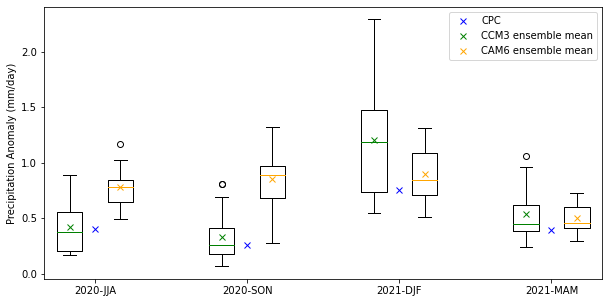

In [6]:
fig = plt.figure(figsize=(10,5))
d_NOAA = []
d_CCM3 = []
d_CCM3_em = []
d_CAM6 = []
d_CAM6_em = []
for season in range(0,4):
    ds = TSa['NOAA'][season].values
    d_NOAA += [ds]
    ds = TSa['CCM3'][:,season].values
    d_CCM3 += [ds]
    d_CCM3_em += [ds.mean()]
    ds = TSa['CAM6'][:,season].values
    d_CAM6 += [ds]
    d_CAM6_em += [ds.mean()]

left_positions = [0, 3, 6, 9]
right_positions = [1, 4, 7, 10]
center = [0.5, 3.5, 6.5, 9.5]
labels = ['2020-JJA','2020-SON','2021-DJF','2021-MAM']
plt.boxplot(d_CCM3, positions = left_positions, medianprops=dict(color='g'))
plt.boxplot(d_CAM6, positions = right_positions, medianprops=dict(color='orange'))
plt.plot(center,d_NOAA,'x',linewidth=0.0,label='CPC',color='b')
plt.plot(left_positions,d_CCM3_em,'x',linewidth=0.0,label='CCM3 ensemble mean',color='g')
plt.plot(right_positions,d_CAM6_em,'x',linewidth=0.0,label='CAM6 ensemble mean',color='orange')
plt.xticks(center, labels)
plt.ylabel('Precipitation Anomaly (mm/day)')
plt.legend()

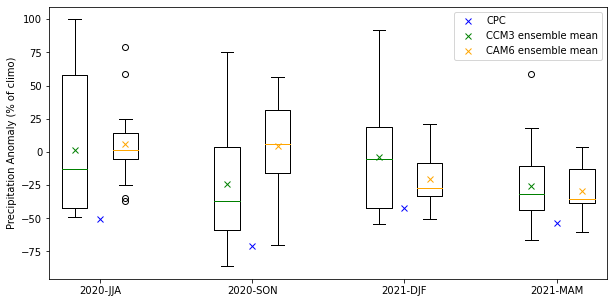

In [7]:
fig = plt.figure(figsize=(10,5))
d_NOAA = []
d_CCM3 = []
d_CCM3_em = []
d_CAM6 = []
d_CAM6_em = []
for season in range(0,4):
    ds = TSp['NOAA'][season].values
    d_NOAA += [ds]
    ds = TSp['CCM3'][:,season].values
    d_CCM3 += [ds]
    d_CCM3_em += [ds.mean()]
    ds = TSp['CAM6'][:,season].values
    d_CAM6 += [ds]
    d_CAM6_em += [ds.mean()]

left_positions = [0, 3, 6, 9]
right_positions = [1, 4, 7, 10]
center = [0.5, 3.5, 6.5, 9.5]
labels = ['2020-JJA','2020-SON','2021-DJF','2021-MAM']
plt.boxplot(d_CCM3, positions = left_positions, medianprops=dict(color='g'))
plt.boxplot(d_CAM6, positions = right_positions, medianprops=dict(color='orange'))
plt.plot(center,d_NOAA,'x',linewidth=0.0,label='CPC',color='b')
plt.plot(left_positions,d_CCM3_em,'x',linewidth=0.0,label='CCM3 ensemble mean',color='g')
plt.plot(right_positions,d_CAM6_em,'x',linewidth=0.0,label='CAM6 ensemble mean',color='orange')
plt.xticks(center, labels)
plt.ylabel('Precipitation Anomaly (% of climo)')
plt.legend()